In [ ]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract

Mounted at /content/drive


In [ ]:
# import raw data and params.txt file

datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"
raw_data = load_data(path=datadir_path,as_df=False)
params_data = load_params(path=datadir_path)
# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading data into numpy array. Took 16.76s
Finsihed loading parameters file


In [ ]:
print(raw_data.shape)
offset = 150
shifted_data, center = get_window(raw_data,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 942)
The Echo pulse occurs at timestep: 628


In [ ]:
polyfeatures = poly_featextract(rscl_data, n_splits=[2,4,5,10], order_fits=[3,3,3,3], as_df=True)

In [ ]:
polyfeatures.head()

,2_1_0,2_1_1,2_1_2,2_1_3,2_2_0,2_2_1,2_2_2,2_2_3,4_1_0,4_1_1,4_1_2,4_1_3,4_2_0,4_2_1,4_2_2,4_2_3,4_3_0,4_3_1,4_3_2,4_3_3,4_4_0,4_4_1,4_4_2,4_4_3,5_1_0,5_1_1,5_1_2,5_1_3,5_2_0,5_2_1,5_2_2,5_2_3,5_3_0,5_3_1,5_3_2,5_3_3,5_4_0,5_4_1,5_4_2,5_4_3,...,10_1_0,10_1_1,10_1_2,10_1_3,10_2_0,10_2_1,10_2_2,10_2_3,10_3_0,10_3_1,10_3_2,10_3_3,10_4_0,10_4_1,10_4_2,10_4_3,10_5_0,10_5_1,10_5_2,10_5_3,10_6_0,10_6_1,10_6_2,10_6_3,10_7_0,10_7_1,10_7_2,10_7_3,10_8_0,10_8_1,10_8_2,10_8_3,10_9_0,10_9_1,10_9_2,10_9_3,10_10_0,10_10_1,10_10_2,10_10_3
0,0.000001,0.000078,0.000389,-0.000389,-1.170266e-06,0.000078,-0.000084,-0.005874,2.236470e-07,0.000006,0.000135,0.011056,0.000004,0.000259,0.007989,0.151059,-0.000004,0.000274,-0.008279,0.146295,-2.149142e-07,6.155184e-06,-0.000127,0.010173,4.935042e-08,-9.564643e-07,0.000146,0.010836,0.000001,0.000088,0.002330,0.050902,-1.240648e-06,-0.000796,0.000025,0.788313,-0.000002,0.000088,-0.002004,0.043527,...,-0.000004,3.937068e-07,0.000778,0.007660,2.546437e-08,0.000025,0.000113,0.011351,0.000003,0.000015,0.000244,0.031908,0.000005,0.000144,0.005397,0.110987,0.000009,0.000671,0.025493,0.506981,4.404496e-08,0.000656,-0.026719,0.493492,-0.000005,0.000145,-0.005154,0.099619,-3.561492e-06,0.000002,-0.000040,0.029204,0.000001,0.000023,-0.000220,0.010351,0.000003,-4.742971e-07,-0.000630,0.007237
1,0.000001,0.000078,0.000448,0.001242,-1.187043e-06,0.000078,0.000027,-0.008931,2.215008e-07,0.000007,0.000148,0.011400,0.000004,0.000257,0.008087,0.155030,-0.000004,0.000277,-0.008140,0.139200,-2.150578e-07,5.847759e-06,-0.000100,0.009622,5.348174e-08,-7.629906e-07,0.000151,0.011101,0.000001,0.000088,0.002405,0.052983,-8.409482e-07,-0.000797,-0.000491,0.787621,-0.000002,0.000088,-0.001867,0.039771,...,-0.000004,3.085515e-06,0.000780,0.007683,6.577907e-08,0.000028,0.000119,0.011560,0.000003,0.000017,0.000310,0.033036,0.000005,0.000144,0.005447,0.114158,0.000009,0.000658,0.025438,0.512003,-4.031941e-07,0.000675,-0.026876,0.485822,-0.000005,0.000146,-0.005067,0.093880,-3.919389e-06,-0.000003,0.000076,0.027217,0.000001,0.000016,-0.000196,0.010274,0.000003,-7.368338e-06,-0.000562,0.007548
2,0.000001,0.000078,0.000309,0.002121,-1.406986e-06,0.000078,0.001366,-0.040420,3.011159e-07,0.000003,0.000062,0.015478,0.000004,0.000259,0.007630,0.150626,-0.000006,0.000335,-0.006469,0.054775,1.576197e-07,-4.457967e-07,-0.000172,0.005378,1.130315e-07,-6.060068e-06,0.000133,0.015633,0.000001,0.000084,0.002449,0.053891,6.345070e-07,-0.000842,-0.003147,0.763734,-0.000003,0.000060,0.000137,0.004831,...,-0.000005,-7.924675e-06,0.001086,0.011249,5.534691e-07,0.000026,-0.000077,0.014808,0.000004,0.000024,0.000249,0.032969,0.000005,0.000132,0.005112,0.113869,0.000010,0.000707,0.025671,0.501332,-2.417505e-06,0.000851,-0.029530,0.405186,-0.000002,0.000219,-0.003503,0.021530,5.906802e-07,0.000006,-0.000393,0.007274,0.000003,-0.000022,-0.000514,0.008249,0.000002,-2.192775e-07,-0.000209,0.003928
3,0.000003,0.000026,-0.008515,0.398645,4.961528e-07,0.000024,-0.004569,0.453401,3.582810e-06,-0.000153,0.003142,0.558517,-0.000004,0.000325,0.012640,0.249613,-0.000021,-0.000052,0.015769,0.671904,-1.123982e-05,-7.467074e-05,0.011848,0.386328,1.741358e-05,-2.428894e-04,-0.003017,0.518130,0.000002,0.000552,-0.010246,0.174025,5.025033e-06,-0.000381,-0.002618,0.771057,0.000023,-0.000455,-0.021611,0.691974,...,-0.000018,-1.136943e-04,0.019888,0.354187,6.979802e-05,0.002911,-0.011550,0.323371,-0.000007,0.000789,-0.020678,0.440769,-0.000007,0.000016,0.012085,0.181037,-0.000208,0.000602,0.045921,0.610748,-9.352133e-05,0.001560,0.001255,0.527728,-0.000060,-0.001001,0.023720,0.813619,-1.219899e-04,0.000352,0.002809,0.339447,0.000053,-0.000710,-0.002286,0.344669,-0.000009,-9.708226e-04,-0.012851,0.510316
4,0.000001,0.000078,0.000552,0.005029,-1.220619e-06,0.000078,0.000267,-0.016190,1.944124e-07,0.000007,0.000210,0.012615,0.000004,0.000254,0.008289,0.162810,-0.000004,0.000285,-0.007789,0.123668,-2.987454e-07,4.270846e-06,0.000077,0.008701,2.661306e-08,1.556227e-07,0.000202,0.01

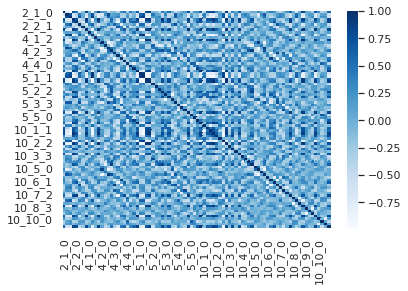

In [ ]:
sns.heatmap(polyfeatures.corr(), cmap='Blues')

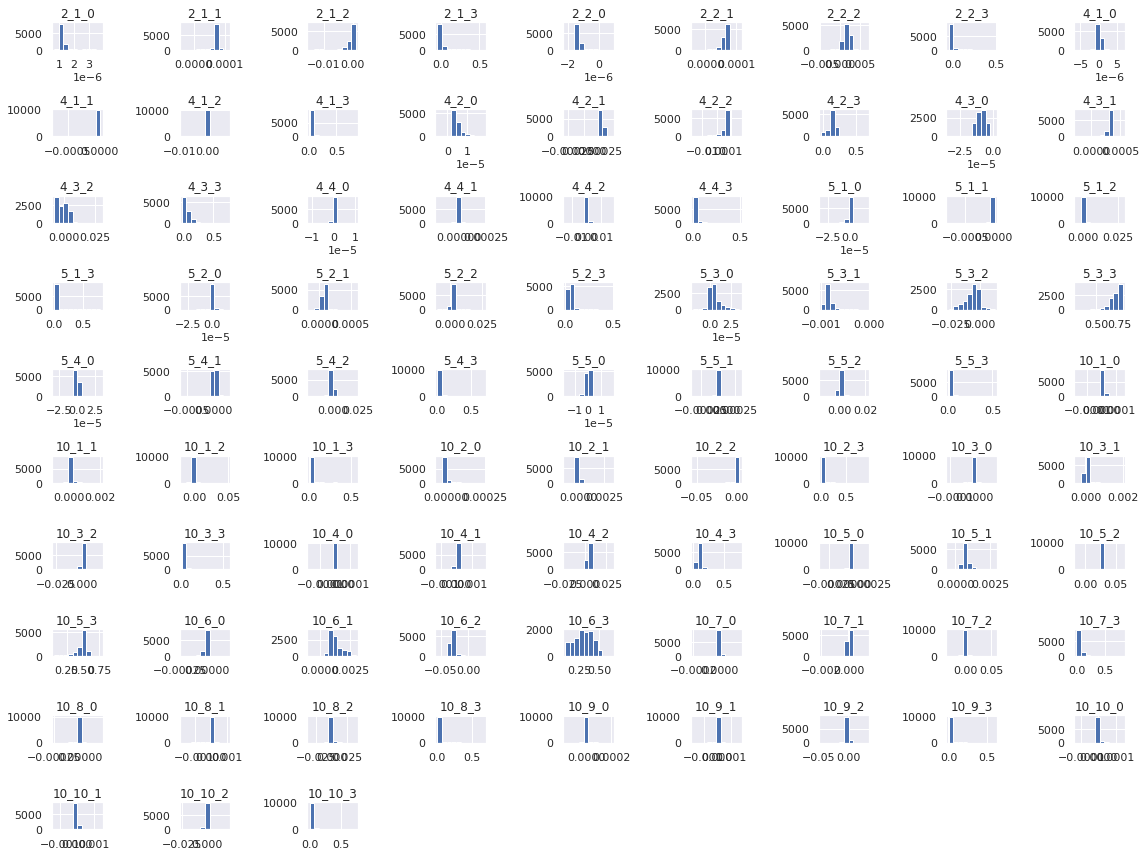

In [ ]:
polyfeatures.hist(figsize=(16,12))
plt.tight_layout()
plt.show()

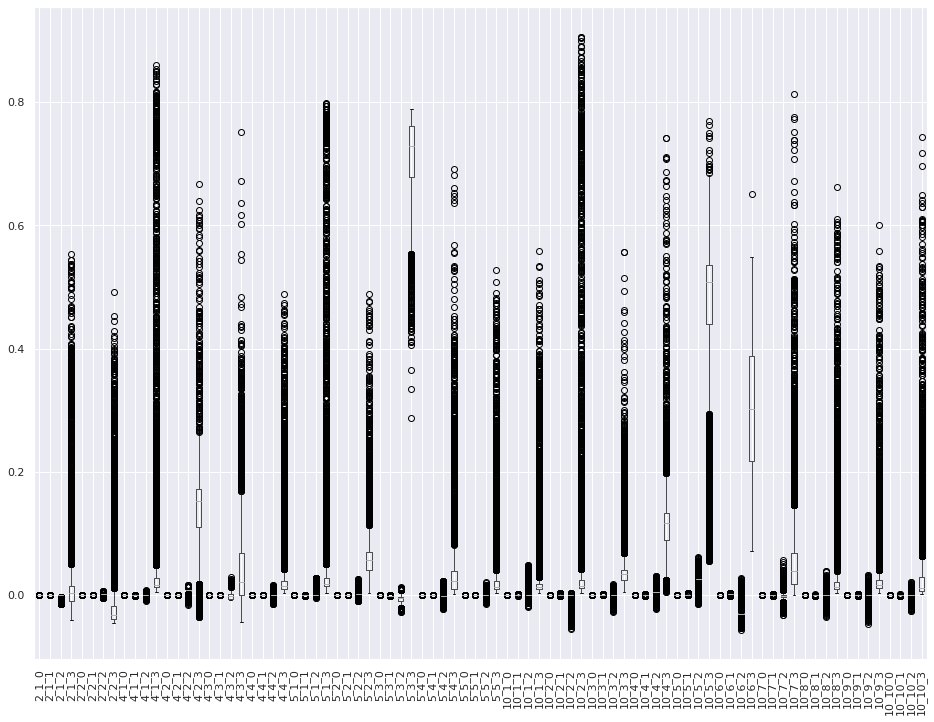

In [ ]:
polyfeatures.boxplot(figsize=(16,12))
plt.xticks(rotation=90)
plt.show()

# Machine Learning

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline

# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate

# Linear Models

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# Tree models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Setup Pipeline

def linear_pipeline(model):
    pipe = Pipeline([
            ('scaler', QuantileTransformer(output_distribution='normal')),
            ('model', model)     
    ])
    return pipe

def tree_pipeline(model):
    return Pipeline([('model', model)])

def get_model_statistics(model,X,y, linear=True):
    """For the given model (linear or tree type) computes the 5-fold CV metrics 
    and returns a dataframe object with metric statistics"""
    modelname = str(model).split('(')[0]
    print(f"Running CV for model: {modelname}")
    
    scores = ['accuracy','precision_weighted','recall_weighted','f1_weighted','roc_auc_ovr_weighted']

    if linear == True:
        results_kf = cross_validate(estimator=linear_pipeline(model), 
                                    verbose=True, X=X, y=y,
                                    scoring=scores, cv=5, n_jobs=-1)
        results_kf_df = pd.DataFrame(results_kf)
    
    if linear == False:
        results_kf = cross_validate(estimator=tree_pipeline(model), verbose=True,
                            X=X, y=y, scoring=scores, cv=5, n_jobs=-1)
        results_kf_df = pd.DataFrame(results_kf)


    return {f'{modelname}_Mean': dict(results_kf_df.mean()), 
            f'{modelname}_Std': dict(results_kf_df.std()),
            f'{modelname}_params' : str(model)}

In [ ]:
X, y = polyfeatures, params_data['stencil_type'].values

In [ ]:
# Try out for SVC 

svm = LinearSVC(multi_class='ovr',random_state=0)
res = get_model_statistics(svm, X,y, linear=True)

Running CV for model: LinearSVC


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.6s finished


In [ ]:
res

{'LinearSVC_Mean': {'fit_time': 4.618534660339355,
  'score_time': 0.1632014274597168,
  'test_accuracy': 0.9219047619047618,
  'test_f1_weighted': 0.9217865914907568,
  'test_precision_weighted': 0.9228398696051869,
  'test_recall_weighted': 0.9219047619047618},
 'LinearSVC_Std': {'fit_time': 0.6725775881327016,
  'score_time': 0.026843542488231276,
  'test_accuracy': 0.0031765866819348353,
  'test_f1_weighted': 0.0032994673629416845,
  'test_precision_weighted': 0.003635181313685911,
  'test_recall_weighted': 0.0031765866819348353},
 'LinearSVC_params': "LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,\n          intercept_scaling=1, loss='squared_hinge', max_iter=1000,\n          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,\n          verbose=0)"}

In [ ]:
# Try out ovevsrest SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

In [ ]:
res2 = get_model_statistics(OneVsRestClassifier(SVC()), X,y, linear=True)

Running CV for model: OneVsRestClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.1s finished


In [ ]:
res2

{'OneVsRestClassifier_Mean': {'fit_time': 9.901867961883545,
  'score_time': 2.155963134765625,
  'test_accuracy': 0.9576190476190476,
  'test_f1_weighted': 0.9575864388752688,
  'test_precision_weighted': 0.9601927449481666,
  'test_recall_weighted': 0.9576190476190476},
 'OneVsRestClassifier_Std': {'fit_time': 0.768972259399299,
  'score_time': 0.24256454033056749,
  'test_accuracy': 0.00496015872761898,
  'test_f1_weighted': 0.004971460034856306,
  'test_precision_weighted': 0.004445690966510914,
  'test_recall_weighted': 0.00496015872761898},
 'OneVsRestClassifier_params': "OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,\n                                  class_weight=None, coef0=0.0,\n                                  decision_function_shape='ovr', degree=3,\n                                  gamma='scale', kernel='rbf', max_iter=-1,\n                                  probability=False, random_state=None,\n                                  shrinking=True

### Linear Models

In [ ]:
Linearmodels = [KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
                LogisticRegression(multi_class='ovr',n_jobs=-1, max_iter=800),
                LogisticRegression(multi_class='multinomial',n_jobs=-1, max_iter=800),
                SGDClassifier(loss='modified_huber',shuffle=True, random_state=0), 
                GaussianProcessClassifier(random_state=0, multi_class='ovr',n_jobs=-1),
                GaussianNB(), BernoulliNB()]

In [ ]:
LinearResults = []
for model in Linearmodels:
    LinearResults.append(get_model_statistics(model, X,y, linear=True))
    print()

Running CV for model: KNeighborsClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Running CV for model: LogisticRegression


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Running CV for model: LogisticRegression


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Running CV for model: SGDClassifier


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Running CV for model: GaussianProcessClassifier


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Running CV for model: GaussianNB


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Running CV for model: BernoulliNB



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


In [ ]:
LinearResults

[{'KNeighborsClassifier_Mean': {'fit_time': 0.632863187789917,
   'score_time': 1.4683123588562013,
   'test_accuracy': 0.9643809523809523,
   'test_f1_weighted': 0.9644180361818331,
   'test_precision_weighted': 0.9651568813313188,
   'test_recall_weighted': 0.9643809523809523,
   'test_roc_auc_ovr_weighted': 0.9906922789115647},
  'KNeighborsClassifier_Std': {'fit_time': 0.042833407161907026,
   'score_time': 0.3424614123743455,
   'test_accuracy': 0.004101877231877715,
   'test_f1_weighted': 0.004078176449249901,
   'test_precision_weighted': 0.003838257893424007,
   'test_recall_weighted': 0.004101877231877715,
   'test_roc_auc_ovr_weighted': 0.0019979864735569846},
  'KNeighborsClassifier_params': "KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,\n                     weights='uniform')"},
 {'LogisticRegression_Mean': {'fit_time': 2.324591875076294,
   'score_time': 0.32627391815185547

In [ ]:
with open("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks/polyfeat_linearmodels.txt",'w') as wf:
    wf.write(str(LinearResults))

### Tree Models

In [ ]:
treemodels = [DecisionTreeClassifier(), 
              ExtraTreesClassifier(), 
              #GradientBoostingClassifier(), 
              RandomForestClassifier()]

In [ ]:
TreeResults = []
for model in treemodels:
    TreeResults.append(get_model_statistics(model, X,y, linear=False))
    print()

Running CV for model: DecisionTreeClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Running CV for model: ExtraTreesClassifier


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Running CV for model: RandomForestClassifier



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished


In [ ]:
TreeResults

[{'DecisionTreeClassifier_Mean': {'fit_time': 1.1394635677337646,
   'score_time': 0.012292623519897461,
   'test_accuracy': 0.9393333333333335,
   'test_f1_weighted': 0.9393652189548319,
   'test_precision_weighted': 0.9394472525236927,
   'test_recall_weighted': 0.9393333333333335,
   'test_roc_auc_ovr_weighted': 0.9545},
  'DecisionTreeClassifier_Std': {'fit_time': 0.18454574379444807,
   'score_time': 0.0019950177259298674,
   'test_accuracy': 0.006714116850291264,
   'test_f1_weighted': 0.006722414740276703,
   'test_precision_weighted': 0.006724211731837951,
   'test_recall_weighted': 0.006714116850291264,
   'test_roc_auc_ovr_weighted': 0.00503558763771844},
  'DecisionTreeClassifier_params': "DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',\n                       max_depth=None, max_features=None, max_leaf_nodes=None,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=1, min_samples_spl

In [ ]:
with open("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks/treemodel_polyfeats_results.txt", 'w') as wf:
    wf.write(str(TreeResults))

## GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
base_model = RandomForestClassifier(n_estimators=10,random_state=42)
base_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
base_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
pipe = Pipeline([
                 ('model', RandomForestClassifier(random_state=0, n_jobs=-1))
])

In [ ]:
params_new = {
    'model__n_estimators' : [10,20,40,60,100,200,300, 1000],
    'model__max_depth' : [80,90,100,110], 
    'model__max_features' : [2,3],
    'model__min_samples_leaf': [3,4],
    'model__min_samples_split' : [8,10,12], 
    'model__criterion' : ['gini','entropy']

}

In [ ]:
?GridSearchCV

In [ ]:
gridsearch = GridSearchCV(estimator=pipe, param_grid =params_new, n_jobs=-1, cv=3, verbose=True)

In [97]:
gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 68.9min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed: 96.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                            

In [99]:
gridsearch.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 80,
 'model__max_features': 3,
 'model__min_samples_leaf': 3,
 'model__min_samples_split': 8,
 'model__n_estimators': 300}

In [98]:
gridsearch.best_score_

0.9511904761904763